In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam
from keras.applications import DenseNet169
from tensorflow.keras.utils import plot_model

# Supress info, warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
disease_types = ['HEART_DISEASE', 'NORMAL']

train_dir = data_dir = '/content/drive/MyDrive/heart_disease_prediction/dataset'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train

,File,ID,Disease Type
0,HEART_DISEASE/disease (141).png,0,HEART_DISEASE
1,HEART_DISEASE/disease (21).png,0,HEART_DISEASE
2,HEART_DISEASE/disease (196).png,0,HEART_DISEASE
3,HEART_DISEASE/disease (124).png,0,HEART_DISEASE
4,HEART_DISEASE/disease (192).png,0,HEART_DISEASE
...,...,...,...
2486,NORMAL/normal (1198).png,1,NORMAL
2487,NORMAL/normal (1133).png,1,NORMAL
2488,NORMAL/normal (1163).png,1,NORMAL
2489,NORMAL/normal (1164).png,1,NORMAL


,File,ID,Disease Type
0,HEART_DISEASE/disease (842).png,0,HEART_DISEASE
1,HEART_DISEASE/disease (1159).png,0,HEART_DISEASE
2,HEART_DISEASE/disease (196).png,0,HEART_DISEASE
3,HEART_DISEASE/disease (965).png,0,HEART_DISEASE
4,HEART_DISEASE/disease (852).png,0,HEART_DISEASE
...,...,...,...
2486,NORMAL/normal (549).png,1,NORMAL
2487,NORMAL/normal (158).png,1,NORMAL
2488,NORMAL/normal (970).png,1,NORMAL
2489,NORMAL/normal (8).png,1,NORMAL


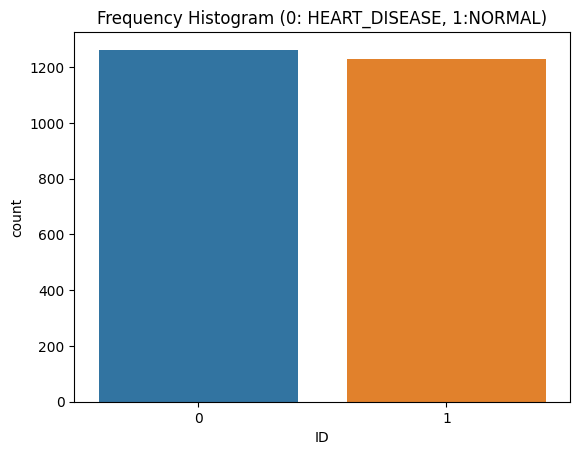

In [4]:
Seed = 40

train = train.sample(frac = 1, replace=False, random_state = Seed)

# Reset indices (row numbers)
train = train.reset_index(drop = True)

sns.countplot(x = "ID", data = train).set_title("Frequency Histogram (0: HEART_DISEASE, 1:NORMAL)")
train

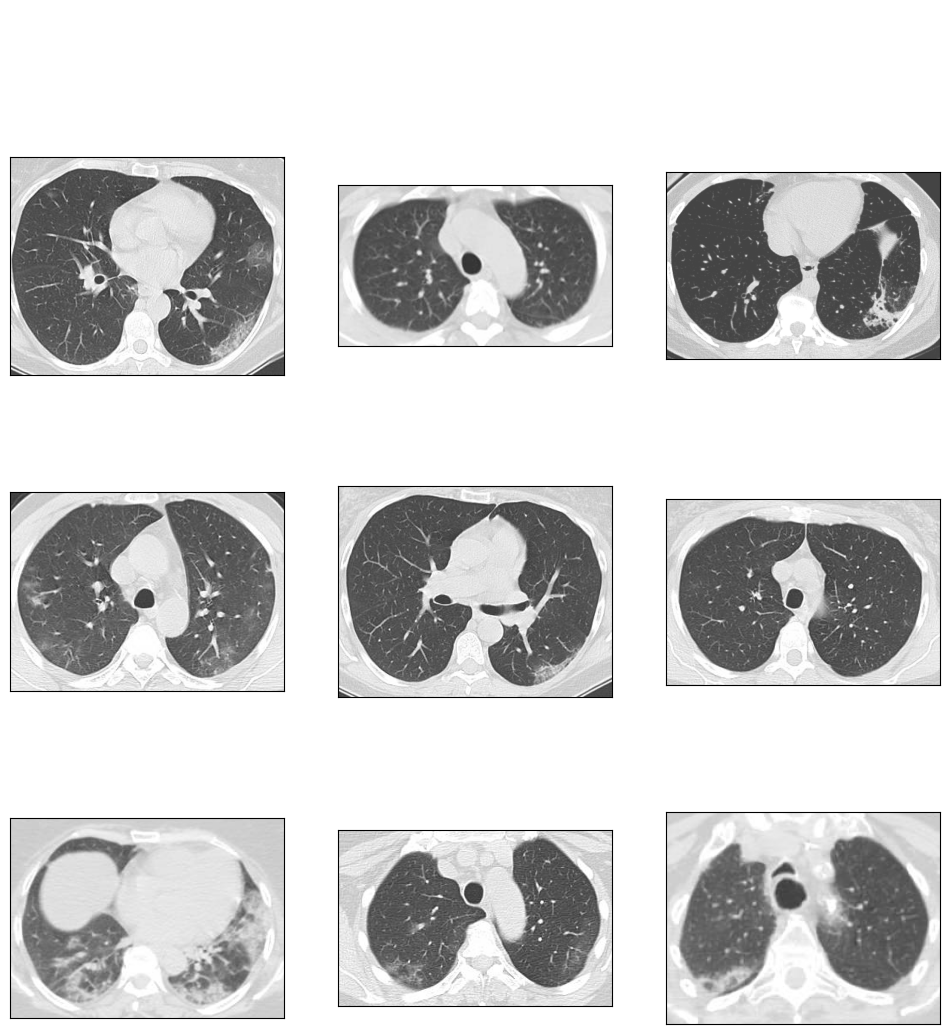

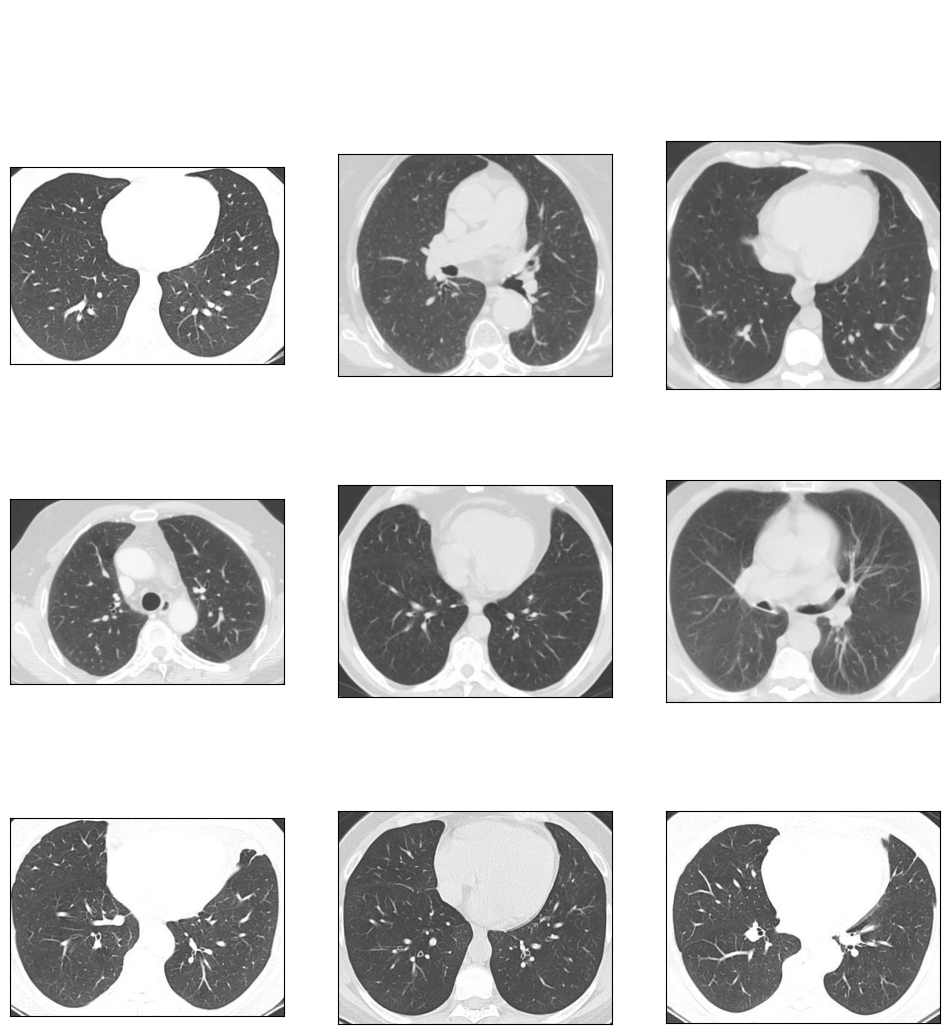

In [5]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    
    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('HEART_DISEASE', 3, 3)
plot_defects('NORMAL', 3, 3)

In [6]:
IMAGE_SIZE = 224

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [7]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

print(Y_train)

Train Shape: (2491, 224, 224, 3)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
# Dataframe split to train and validation set (80% train and 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2, # Percent 20% of the data is using as test set
                                                  random_state = Seed)

print(f'X_train:', X_train.shape)
print(f'X_val:', X_val.shape)
print(f'Y_train:', Y_train.shape)
print(f'Y_val:', Y_val.shape)

X_train: (1992, 224, 224, 3)
X_val: (499, 224, 224, 3)
Y_train: (1992, 2)
Y_val: (499, 2)


In [9]:
# Architectural function for DenseNet-169
def build_desnet169(IMAGE_SIZE, channels):

    densetnet169 = DenseNet169(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = densetnet169(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    output = Dense(2, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

51877672/51877672 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                              

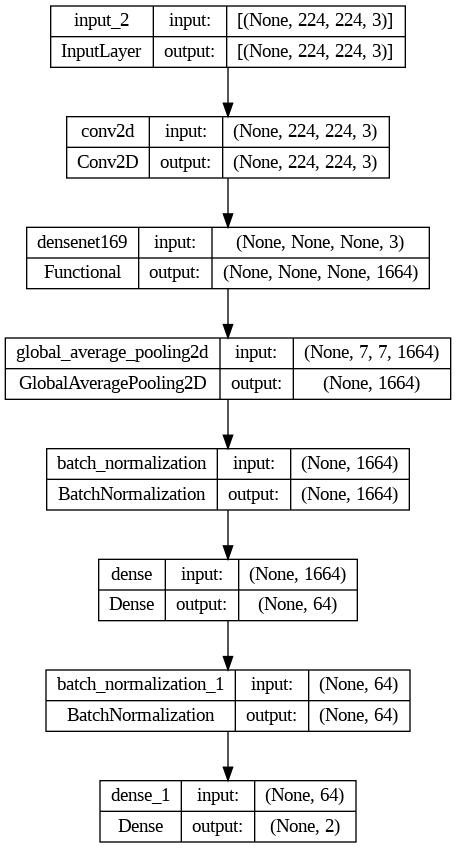

In [10]:
channels = 3

model = build_desnet169(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 1,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('dense.h5', verbose = 1, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

In [11]:
BATCH_SIZE = 32
EPOCHS = 1

# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (X_val, Y_val))

62/62 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.7490
Epoch 1: val_loss improved from inf to 0.64099, saving model to dense.h5
62/62 [==============================] - 113s 1s/step - loss: 0.5368 - accuracy: 0.7490 - val_loss: 0.6410 - val_accuracy: 0.6172 - lr: 0.0030


In [12]:
from tensorflow.keras.models import load_model

In [13]:
model = load_model('/content/drive/MyDrive/heart_disease_prediction/dataset/model.h5')

16/16 [==============================] - 5s 106ms/step
True Positive: 252
False Negative: 0
True Negative: 246
False Positive: 1
True Positive Rate: 1.0
True Negative Rate: 0.9959514170040485

16/16 [==============================] - 6s 115ms/step - loss: 0.0074 - accuracy: 0.9980

Final Loss: 0.007398401387035847, Final Accuracy: 0.9979959726333618


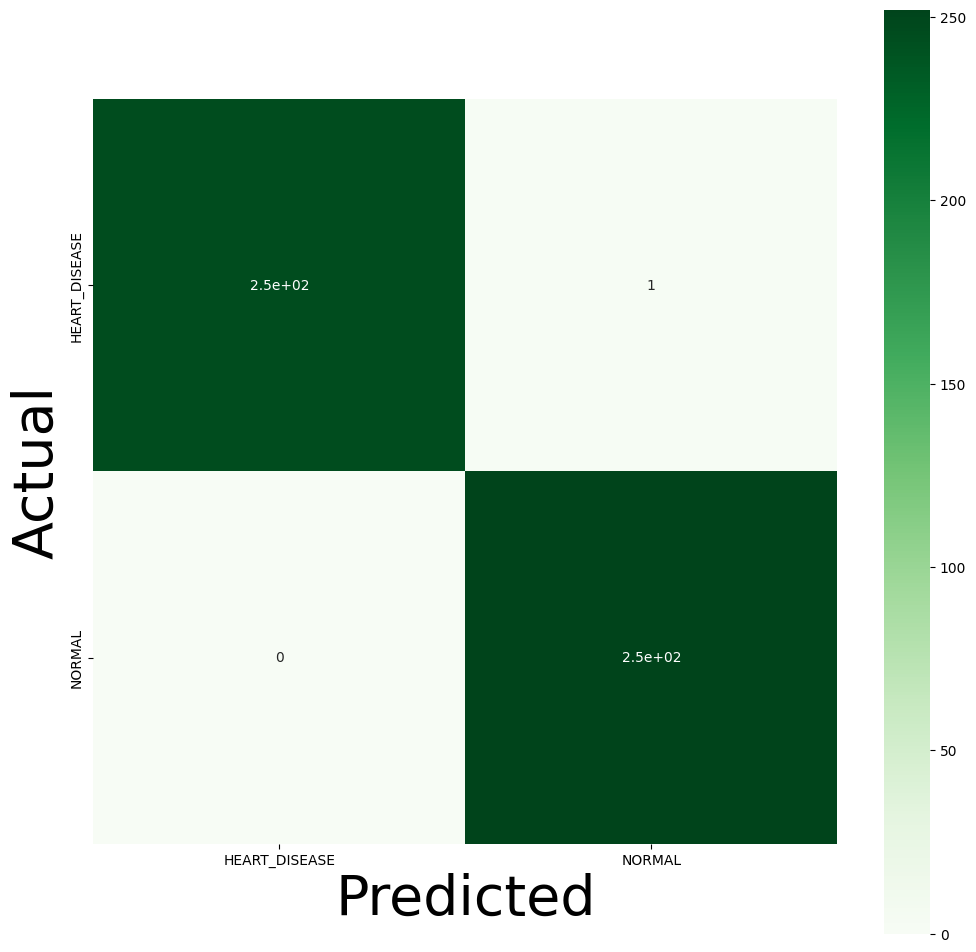

In [14]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

1/1 [==============================] - 0s 41ms/step
[9.9996638e-01 3.3649798e-05]


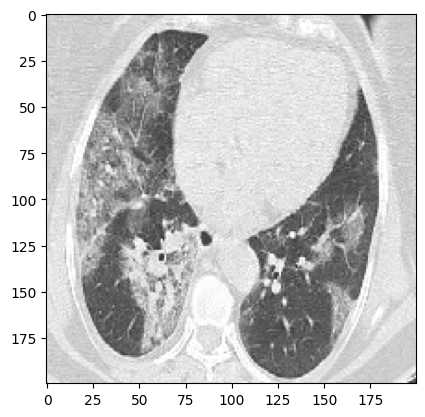

Prediction: HEART_DISEASE


In [16]:
 from tensorflow.keras.preprocessing import image
img_img = '/content/drive/MyDrive/heart_disease_prediction/dataset/HEART_DISEASE/disease (1003).png'
img = image.load_img(img_img, grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = image.load_img(img_img, grayscale = False, target_size = (200, 200))
disease_class = ['HEART_DISEASE','NORMAL']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

# New Section